# Label Propagation

In [15]:

#from shapely.geometry import Point, Polygon
import geopandas as gpd
import requests
from tqdm.auto import tqdm
import numpy as np
from sklearn.semi_supervised import LabelPropagation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import rasterio as rs
from rasterio.mask import mask
from rasterio.merge import merge
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from rasterio.plot import show
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from glob import glob
import os

# Prepare Inputs

## Input Datasets

In [46]:
# gather the tile coordinates for costa rica
# aws s3 cp s3://esa-worldcover-s2/rgbnir/2020/N08/ESA_WorldCover_10m_2020_v100_N08W083_S2RGBNIR.tif /Users/jessica.ertel/plantation_classifier/data/label_prop/costa_rica/s2/

coords1 = []
coords2 = []
for file in glob(f'../data/label_prop/costa_rica/s2/*.tif'):
    coords2.append(file[-20:-13])

In [43]:
# s2 file downloads from s3
coords1

['N09W085',
 'N10W085',
 'N11W085',
 'N10W084',
 'N09W084',
 'N11W084',
 'N08W084',
 'N08W083',
 'N09W083',
 'N10W083',
 'N11W086',
 'N10W086',
 'N09W086']

In [47]:
coords2

['N11W086',
 'N09W084',
 'N09W083',
 'N09W085',
 'N08W083',
 'N08W084',
 'N10W086',
 'N10W085',
 'N10W084',
 'N10W083',
 'N11W085',
 'N11W084',
 'N09W086']

In [12]:
# Mosaic sentinel files then clip to Costa Rica boundary

def merge_and_clip(country, data):
    
    folder = (f'../data/label_prop/{country}/')

    # now open each item in dataset reader mode (required to merge)
    reader_mode = []

    for file in glob(f'{folder}{data}/*.tif'):
        src = rs.open(file)
        reader_mode.append(src) 

    # for s2 and s1 nodata value is 0
    mosaic, out_transform = merge(reader_mode)
    
    # outpath will be the new filename
    merged = f'{folder}{country + data}_merged.tif'
    out_meta = src.meta.copy()  
    out_meta.update({'driver': "GTiff",
                     'dtype': 'float32',  #for s2 should be uint16, float32 for s1
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_transform,
                     'compress':'lzw'})

    with rs.open(merged, "w", **out_meta, BIGTIFF='YES') as dest:
        dest.write(mosaic)

    # now clip merged tif to country boundaries
    merged = f'{folder}{country + data}_merged.tif'
    shapefile = gpd.read_file(f'{folder}gadm41_CRI_0.shp')
    clipped = f'{folder}{country + data}_clipped.tif'

    with rs.open(merged) as src:
        shapefile = shapefile.to_crs(src.crs)
        out_image, out_transform = mask(src, shapefile.geometry, crop=True)
        out_meta = src.meta.copy() 

    out_meta.update({
        "driver":"Gtiff",
        "height":out_image.shape[1], # height starts with shape[1]
        "width":out_image.shape[2], # width starts with shape[2]
        "transform":out_transform
    })

    with rs.open(clipped,'w',**out_meta, BIGTIFF='YES') as dst:
        dst.write(out_image)
    
    print(f'{len(reader_mode)} tifs merged and clipped to {country}.')
    os.remove(merged)
    return None

In [74]:
#merge_and_clip('costa_rica', 's2')

In [7]:
## reproject the lulc dataset to espg 4326 to match other input data
## taken verbatim from rasterio documentation w/ added compression params

from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rs.open('../data/testing/lulc_cr.tif') as src:
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'compress': 'lzw',
        'dtype': 'uint8'})

    with rs.open('../data/testing/lulc_cr_reprj.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rs.band(src, i),
                destination=rs.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

## Input Points

In [21]:
folder = ('../data/label_prop/')
ttc = rs.open(f'{folder}/costa_rica/CostaRica.tif')
sdpt = gpd.read_file(f'{folder}cri_sdpt_v2.shp')
lulc = rs.open(f'{folder}lulc_cr_2016.tif')
cr = gpd.read_file(f'{folder}/costa_rica/gadm41_CRI_0.shp')
hc_poly = gpd.read_file(f'{folder}HighConf_poly1.shp')
labeled = gpd.read_file(f'{folder}HighConf_Point.shp')
unlabeled = gpd.read_file(f'{folder}output_unlabelledPts.shp')

In [39]:
s1 = rs.open(f'{folder}/costa_rica/costa_ricas1_clipped.tif')
s2 = rs.open(f'{folder}/costa_rica/costa_ricas2_clipped.tif')

In [27]:
s1.shape, s2.shape

((38638, 41373), (38638, 41373))

### Labeled Points
In the future, this step would be removed or ideally combined with preprocessing steps for unlabeled points. For now, will import the previously gathered labeled data.

In [28]:
# clean up column names
labeled.drop(columns=['Id', 'Area', 'gridcode', 'MERGE_SRC', 'ORIG_FID'], inplace=True)
labeled.columns = map(str.lower, labeled.columns)
labeled.rename(columns={'pclass': 'label', 'ttc_thres':'ttc'}, inplace=True)

# clean up vals and dtypes to match what will be extracted
labeled.sdpt = labeled.sdpt.map({'NA': 0.0, 'ForestPlantation': 2.0, 'oilpalm': 1.0, 'orchard': 3.0}).astype('str')
labeled.lulc = labeled.lulc.map({'urban': 10.0, 
                                 'MatureForest': 8.0,
                                 'mangrove':14.0,
                                 'FPlantation':7.0,
                                 'palm':20.0,
                                 'bare':9.0,
                                 'pineapple':22.0,
                                 'coffeeAg':23.0}).astype('str')
labeled.label = labeled.label.map({'notplantation': 0, 'monoculture': 1, 'agroforestry': 2}).astype('str')
labeled.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lulc      2194 non-null   object  
 1   label     2194 non-null   object  
 2   sdpt      2194 non-null   object  
 3   ttc       2194 non-null   int64   
 4   point_x   2194 non-null   float64 
 5   point_y   2194 non-null   float64 
 6   geometry  2194 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 120.1+ KB


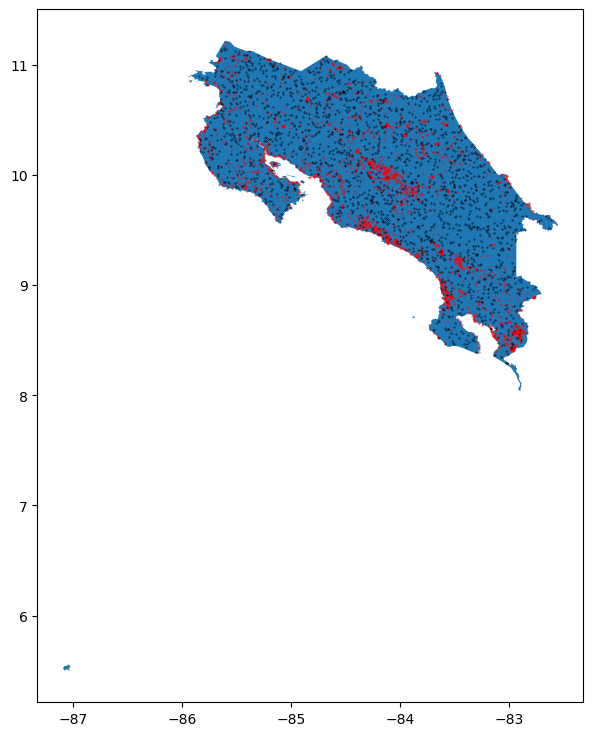

In [6]:
# quick visual to get a sense of the location of labeled and unlabeled points
ax = cr.plot(figsize=(11,9))
labeled.plot(ax=ax, color='red', markersize=0.1)
unlabeled.plot(ax=ax, color='black', markersize=0.1);

### Prepare Unlabeled Points

In [29]:
def extract_raster_values(raster, points):
    
    values = []
    for point in points.geometry:
        x, y = point.x, point.y
        row, col = raster.index(x, y)

        # Check if the point is within the raster extent
        if 0 <= row < raster.height and 0 <= col < raster.width:
            value = raster.read(1, window=((row, row + 1), (col, col + 1)))
            values.append(value[0][0])
        else:
            values.append(np.NaN)
            
    return values


In [35]:
def get_unlabeled_data(num_pts):
    
    '''
    Calculates num_pts within a designated area and extracts associated 
    attributes from 3 rasters. Returns dataframe where each row
    represents an unlabeled observation.
    
    '''
    
    # gets num_pts of unlabeled data
    print(f'Extracting {num_pts} unlabeled points...')
    print('(points are currently imported)')
    
    # for now import Kanchana's generated points
    unlabeled = gpd.read_file('../data/label_prop/output_unlabelledPts.shp')
    
    # add line to avoid points on cocos island
    # add line to drop any points that are NaN or 255 from TTC or LULC

    # import ttc, sdpt and lulc data and confirm crs
    ttc = rs.open('../data/label_prop/costa_rica/CostaRica.tif')
    sdpt = gpd.read_file('../data/label_prop/cri_sdpt_v2.shp')
    lulc = rs.open('../data/label_prop/lulc_cr_reprj.tif')
    
    assert ttc.crs == sdpt.crs == lulc.crs == unlabeled.crs
    
    # create new df to hold extracted attributes
    df = pd.DataFrame(columns=['lulc', 'label', 'sdpt', 'ttc', 'point_x', 'point_y','geometry'])
    df['geometry'] = unlabeled.geometry
    df['point_x'] = unlabeled.geometry.x
    df['point_y'] = unlabeled.geometry.y
    df['lulc'] = extract_raster_values(lulc, unlabeled)
    df['ttc'] = extract_raster_values(ttc, unlabeled)

    # for sdpt must perform join
    # forest plantations = 2.0, orchard = 7215, oil palm = 1.0
    intersection = gpd.sjoin(unlabeled, sdpt[['originalCo', 'originalNa', 'geometry']], how='left', predicate='within')
    df['sdpt'] = intersection['originalCo']
    
    # take care of null values for modeling
    df['sdpt'] = df['sdpt'].fillna(0)
    df['label'] = df['label'].fillna(-1)
    
    # drop the point on cocos island
    df.drop(index=89, inplace=True)
    
    df[['lulc', 'label', 'sdpt']] = df[['lulc', 'label', 'sdpt']].astype(str)
    df['ttc'] = df['ttc'].astype(np.int64)
    
    return df

In [36]:
unlab_df = get_unlabeled_data(2000)
unlab_df.head()

Extracting 2000 unlabeled points...
(points are currently imported)


,lulc,label,sdpt,ttc,point_x,point_y,geometry
0,7.0,-1,0.0,40,-84.483444,10.804541,POINT (-84.48344 10.80454)
1,8.0,-1,0.0,90,-84.434508,9.797179,POINT (-84.43451 9.79718)
2,8.0,-1,0.0,90,-82.612486,9.588960,POINT (-82.61249 9.58896)
3,6.0,-1,0.0,60,-83.161090,9.072028,POINT (-83.16109 9.07203)
4,8.0,-1,0.0,90,-85.567580,10.754863,POINT (-85.56758 10.75486)


In [41]:
unlab_df.reset_index(drop=True)

,lulc,label,sdpt,ttc,point_x,point_y,geometry
0,7.0,-1,0.0,40,-84.483444,10.804541,POINT (-84.48344 10.80454)
1,8.0,-1,0.0,90,-84.434508,9.797179,POINT (-84.43451 9.79718)
2,8.0,-1,0.0,90,-82.612486,9.588960,POINT (-82.61249 9.58896)
3,6.0,-1,0.0,60,-83.161090,9.072028,POINT (-83.16109 9.07203)
4,8.0,-1,0.0,90,-85.567580,10.754863,POINT (-85.56758 10.75486)
...,...,...,...,...,...,...,...
1994,4.0,-1,0.0,0,-85.059221,10.962947,POINT (-85.05922 10.96295)
1995,8.0,-1,0.0,90,-83.790549,10.156115,POINT (-83.79055 10.15612)
1996,17.0,-1,0.0,80,-84.048624,10.065363,POINT (-84.04862 10.06536)
1997,6.0,-1,0.0,90,-85.236940,9.779641,POINT (-85.23694 9.77964)


In [37]:
label_df = labeled
label_df.head()

,lulc,label,sdpt,ttc,point_x,point_y,geometry
0,20.0,1,1.0,40,-83.598904,10.540394,POINT (-83.59890 10.54039)
1,20.0,1,1.0,40,-83.780329,10.496399,POINT (-83.78033 10.49640)
2,20.0,1,1.0,40,-83.798637,10.495866,POINT (-83.79864 10.49587)
3,20.0,1,1.0,40,-83.770438,10.491470,POINT (-83.77044 10.49147)
4,20.0,1,1.0,40,-83.776915,10.492586,POINT (-83.77692 10.49259)


In [60]:
## extract Sentinel-1 and Sentinel-2 values for labeled and unlabeled data
unlab_df['s1'] = pd.Series(extract_raster_values(s1, unlabeled), dtype=np.float32)
label_df['s1'] = extract_raster_values(s1, labeled)
unlab_df['s2'] = pd.Series(extract_raster_values(s2, unlabeled), dtype=np.float32)
label_df['s2'] = extract_raster_values(s2, labeled)

In [61]:
unlab_df.head()

,lulc,label,sdpt,ttc,point_x,point_y,geometry,s1,s2
0,7.0,-1,0.0,40,-84.483444,10.804541,POINT (-84.48344 10.80454),38442.0,461.0
1,8.0,-1,0.0,90,-84.434508,9.797179,POINT (-84.43451 9.79718),39227.0,411.0
2,8.0,-1,0.0,90,-82.612486,9.588960,POINT (-82.61249 9.58896),37954.0,260.0
3,6.0,-1,0.0,60,-83.161090,9.072028,POINT (-83.16109 9.07203),0.0,323.0
4,8.0,-1,0.0,90,-85.567580,10.754863,POINT (-85.56758 10.75486),38855.0,387.0


In [62]:
label_df.head()

,lulc,label,sdpt,ttc,point_x,point_y,geometry,s1,s2
0,20.0,1,1.0,40,-83.598904,10.540394,POINT (-83.59890 10.54039),39298.0,272.0
1,20.0,1,1.0,40,-83.780329,10.496399,POINT (-83.78033 10.49640),39399.0,293.0
2,20.0,1,1.0,40,-83.798637,10.495866,POINT (-83.79864 10.49587),39381.0,436.0
3,20.0,1,1.0,40,-83.770438,10.491470,POINT (-83.77044 10.49147),39185.0,320.0
4,20.0,1,1.0,40,-83.776915,10.492586,POINT (-83.77692 10.49259),38971.0,333.0


In [83]:
## what to do w/ ttc values
labeled.ttc.value_counts()

80    658
5     538
50    361
40    317
1     232
30     88
Name: ttc, dtype: int64

In [84]:
unlabeled.ttc.value_counts()

90     953
0      519
80     178
60      81
40      72
70      52
255     50
50      37
20      32
30      25
Name: ttc, dtype: int64

## Prepare Model Input
Confirm that the labeled and unlabeled dataframes match so they can be combined as input to the models.

In [65]:
labeled = label_df
unlabeled = unlab_df

In [63]:
display(label_df.info())
display(unlab_df.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lulc      2194 non-null   object  
 1   label     2194 non-null   object  
 2   sdpt      2194 non-null   object  
 3   ttc       2194 non-null   int64   
 4   point_x   2194 non-null   float64 
 5   point_y   2194 non-null   float64 
 6   geometry  2194 non-null   geometry
 7   s1        2194 non-null   float32 
 8   s2        2194 non-null   float32 
dtypes: float32(2), float64(2), geometry(1), int64(1), object(3)
memory usage: 137.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lulc      1999 non-null   object  
 1   label     1999 non-null   object  
 2   sdpt      1999 non-null   object  
 3   ttc       1999 non-null   int64   
 4   point_x   1999 non-null   float64 
 5   point_y   1999 non-null   float64 
 6   geometry  1999 non-null   geometry
 7   s1        1999 non-null   float32 
 8   s2        1999 non-null   float32 
dtypes: float32(2), float64(2), geometry(1), int64(1), object(3)
memory usage: 140.6+ KB


None

In [66]:
X = labeled[['lulc','sdpt','ttc','s1','s2']]
y = labeled['label']

Xun = unlabeled[['lulc','sdpt','ttc','s1','s2']]
yun = unlabeled['label']

# train test split on labeled data--maintain proportions with stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', Xun.shape, yun.shape)
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (1645, 5) (1645,)
Unlabeled Train Set: (1999, 5) (1999,)
Test Set: (549, 5) (549,)


In [67]:
# check class distribution
display(y.value_counts())
display(yun.value_counts())

0    1789
1     317
2      88
Name: label, dtype: int64

-1    1999
Name: label, dtype: int64

## Supervised Learning: Logistic Regression
Perform an initial supervised learning exercise using only the labeled data (to create a baseline for comparison).

In [69]:
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight

In [70]:
# calc weighting to balance classes
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights)) 
class_weights

{'0': 0.40889883171762365, '1': 2.303921568627451, '2': 8.308080808080808}

In [85]:
## without pipeline
X = labeled[['lulc','sdpt','ttc','s1','s2']]
y = labeled['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

X_train = pd.get_dummies(X_train, columns = ['lulc', 'sdpt', 'ttc'])
X_test = pd.get_dummies(X_test, columns = ['lulc', 'sdpt', 'ttc'])

model = LogisticRegression(multi_class='multinomial', 
                          solver='saga', # only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ for multiclass
                          max_iter=8000, 
                          class_weight=class_weights,
                          random_state=22)

model.fit(X_train, y_train)
cv = cross_val_score(model, X_train, y_train, cv=3).mean()
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
probs = model.predict_proba(X_test)
pred = model.predict(X_test)
f1 = f1_score(y_test, pred, average='weighted')
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')  
cv, train_score, test_score, f1, precision, recall

/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetri

(0.43777449820288156,
 0.5082066869300912,
 0.517304189435337,
 0.565446332178541,
 0.6545164628870993,
 0.517304189435337)

In [73]:
pred

array(['2', '1', '2', '2', '1', '2', '1', '2', '2', '1', '1', '2', '2',
       '2', '2', '2', '1', '1', '2', '2', '2', '1', '2', '2', '1', '2',
       '2', '2', '2', '1', '2', '0', '1', '2', '2', '2', '0', '1', '1',
       '2', '2', '2', '1', '2', '2', '2', '2', '0', '2', '2', '2', '1',
       '2', '2', '2', '2', '1', '2', '2', '1', '2', '1', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '1', '2', '2', '1', '2', '2', '2',
       '2', '2', '2', '1', '2', '0', '2', '2', '2', '1', '2', '2', '2',
       '2', '2', '2', '2', '2', '1', '2', '2', '2', '2', '2', '1', '2',
       '1', '2', '2', '1', '1', '2', '2', '2', '0', '1', '2', '1', '2',
       '1', '2', '2', '2', '1', '2', '2', '2', '1', '2', '2', '1', '2',
       '1', '2', '0', '2', '0', '2', '2', '2', '1', '1', '2', '0', '2',
       '1', '1', '2', '2', '1', '2', '2', '2', '2', '2', '1', '1', '1',
       '2', '1', '2', '2', '2', '1', '1', '2', '2', '2', '1', '2', '1',
       '2', '1', '1', '2', '0', '2', '1', '2', '1', '2', '2', '1

## Semi-supervised Learning: Label Propagation
Perform a semi-supervised learning exercise where the algorithm will have the labeled and unlabeled data. Expect the semi-supervised learning algorithm to outperform the logistic regression model fit on the labeled data alone.  
Issue: Labels are categorical. Missing labels must be indicated by -1, however not clear that this approach works for categorical predictions because the algorithm should not be predicting that label.

In [99]:
# create the mixed training dataset
X = labeled[['lulc','sdpt','ttc','point_x','point_y']]
y = labeled['label']

Xun = unlabeled[['lulc','sdpt','ttc','point_x','point_y']]
yun = unlabeled['label']

X_mixed = pd.concat([X, Xun])
y_mixed = pd.concat([y, yun])

# have to train test split after to ensure train and text have same representation
X_train, X_test, y_train, y_test = train_test_split(X_mixed, y_mixed, random_state=22, stratify=y_mixed)

X_train_dum = pd.get_dummies(X_train, columns = ['lulc', 'sdpt'])
X_test_dum = pd.get_dummies(X_test, columns = ['lulc', 'sdpt'])

print('Mixed Train Set:', X_train.shape, y_train.shape)
print('Test Set:', X_test.shape, y_test.shape)

Mixed Train Set: (3144, 5) (3144,)
Test Set: (1049, 5) (1049,)


In [100]:
semisuper_model = LabelPropagation()
semisuper_model.fit(X_train_dum, y_train)
yhat = semisuper_model.predict(X_test_dum)
score = accuracy_score(y_test, yhat)
print(f'Accuracy: {score}')

Accuracy: 0.996186844613918


In [101]:
X_test['preds'] = yhat
X_test.head()

,lulc,sdpt,ttc,point_x,point_y,preds
521,22.0,3.0,5,-83.456717,9.247454,0
1855,8.0,0.0,90,-83.233811,9.874400,-1
357,6.0,0.0,90,-85.728006,10.187768,-1
523,22.0,3.0,5,-83.477466,9.244667,0
972,6.0,0.0,80,-84.899885,9.821463,-1


In [102]:
semisuper_model.classes_

array(['-1', '0', '1', '2'], dtype=object)

## Validation of outputs

In [2]:
# Kanchana's output - no labels
preds = gpd.read_file('../data/testing/preds.shp')
preds

,FID,geometry
0,0,POINT (-84.48344 10.80454)
1,1,POINT (-84.43451 9.79718)
2,2,POINT (-82.61249 9.58896)
3,3,POINT (-83.16109 9.07203)
4,4,POINT (-85.56758 10.75486)
...,...,...
1995,1995,POINT (-85.05922 10.96295)
1996,1996,POINT (-83.79055 10.15612)
1997,1997,POINT (-84.04862 10.06536)
1998,1998,POINT (-85.23694 9.77964)


## What Next
Option 1: Could we use the high confidence labeled centroids to generate a 14 x 14 grid of unlabeled points and use label propagation to label the rest of the points in the grid?

Concerns:
- some points are very close and may have overlapping grids which would need to have the same labels
- some degree of photointerpretation still feels necessary
- should pineapple be considered a monoculture plantation? SDPT labels pineapple as orchard

Roadblock
- in qgis cannot reproject to a crs with meters as units (points move to incorrect locations)


In [104]:
# this is output of Label Propagation vs what we need
ceo = pd.read_csv('../data/ceo-plantations-train-v20.csv')
display(X_test.head())
display(ceo.head())

,lulc,sdpt,ttc,point_x,point_y,preds
521,22.0,3.0,5,-83.456717,9.247454,0
1855,8.0,0.0,90,-83.233811,9.874400,-1
357,6.0,0.0,90,-85.728006,10.187768,-1
523,22.0,3.0,5,-83.477466,9.244667,0
972,6.0,0.0,80,-84.899885,9.821463,-1


,index,PLOT_ID,SAMPLE_ID,LON,LAT,EMAIL,FLAGGED,COLLECTION_TIME,ANALYSIS_DURATION,IMAGERY_TITLE,IMAGERY_ATTRIBUTIONS,SAMPLE_GEOM,SYSTEM,PLOT_FNAME,PLANTATION
0,0,0,-195,-0.894849,6.116158,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116157612001956),Unknown,20001,255
1,1,0,-194,-0.894849,6.116247,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116246932196532),Unknown,20001,255
2,2,0,-193,-0.894849,6.116336,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116336252376186),Unknown,20001,255
3,3,0,-192,-0.894849,6.116426,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116425572540933),Unknown,20001,255
4,4,0,-191,-0.894849,6.116515,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116514892690745),Unknown,20001,255


In [42]:
# what if we use the labeled points to generate a 14x14 grid of 
# unlabeled points and use label propagation to label each grid
labeled.head()

,lulc,label,sdpt,ttc,point_x,point_y,geometry
0,palm,monoculture,1.0,40,-83.598904,10.540394,POINT (-83.59890 10.54039)
1,palm,monoculture,1.0,40,-83.780329,10.496399,POINT (-83.78033 10.49640)
2,palm,monoculture,1.0,40,-83.798637,10.495866,POINT (-83.79864 10.49587)
3,palm,monoculture,1.0,40,-83.770438,10.491470,POINT (-83.77044 10.49147)
4,palm,monoculture,1.0,40,-83.776915,10.492586,POINT (-83.77692 10.49259)


Steps:
1. Reproject your points to a projected CRS with metres as units
2. Draw buffers with a radius of 50m (half of the grid size) around them with `Vector -> Geoprocessing Tools -> buffer(s)`
3. Create the vector grid with the extent of the buffer layer and 10m spacing


## Transform centroid to grid

In [ ]:
def calculate_epsg(points: Tuple[float, float]) -> int:
    """ Calculates the UTM EPSG of an input WGS 84 lon, lat

        Parameters:
         points (tuple): input longitiude, latitude tuple

        Returns:
         epsg_code (int): integer form of associated UTM EPSG
    """
    lon, lat = points[0], points[1]
    utm_band = str((math.floor((lon + 180) / 6) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0' + utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return int(epsg_code)

In [ ]:
def bounding_box(point: Tuple[float, float],
                 x_offset_max: int = 140,
                 y_offset_max: int = 140,
                 expansion: int = 10) -> Tuple[float, float]:

    tl = point

    epsg = calculate_epsg(tl)
    tl = convertCoords(tl, 4326, epsg)

    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max)))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]

    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]

    after = [b - a for a, b in zip(br, tl)]
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)

    min_x = tl[0]  # original X offset - 10 meters
    max_x = br[0]  # original X offset + 10*GRID_SIZE meters

    min_y = tl[1]  # original Y offset - 10 meters
    max_y = br[1]  # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]

# References

© ESA WorldCover project 2020 / Contains modified Copernicus Sentinel data (2020) processed by ESA WorldCover consortium

In [ ]:
## Old

In [71]:
# X = labeled[['lulc','sdpt','ttc','s1','s2']]
# y = labeled['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

# # apply one hot encoding to all categorical variables
# # is this being applied to x_train/x_test
# cat_cols = ['sdpt', 'lulc']
# one_hot = OneHotEncoder(handle_unknown="ignore")
# preprocessor = ColumnTransformer([("one-hot-encoder", one_hot, cat_cols)])

# superv_model = make_pipeline(preprocessor, LogisticRegression(multi_class='multinomial', 
#                                                               solver='sag', 
#                                                               max_iter=500, 
#                                                               class_weight=class_weights,
#                                                               random_state=22))
# superv_model.fit(X_train, y_train)
# yhat = superv_model.predict(X_test)
# score = accuracy_score(y_test, yhat)
# print(f'Accuracy: {score}')

Accuracy: 1.0
